In [2]:
%load_ext autoreload
%autoreload 2
from confignb import *

X, y, pts, ks, masks = util.load_data()

In [ ]:
gs = []

for poi in [10, 20, 50, 100, 200]:
    pl = make_pipeline(
        SelectFromModel(simplerf(SEED), max_features=poi),
        simplerf(SEED),
    )
    results, _ = cv(SEED, pl, X, y, pts, ks, verbose=True)
    logging.info(f"[{poi}] {results['atk_score_mean'].mean():.4f}")

    gs.append(util.results_to_dict(results, poi=poi))
    util.save_results(gs, 'rf_gini')

In [ ]:
gs = []

for pc in [5, 10, 20, 50]:
    pca = PCA(n_components=pc, random_state=SEED)
    pl = make_pipeline(pca, simplerf(SEED))
    results, _ = cv(SEED, pl, X, y, pts, ks, verbose=False)

    logging.info(f'[{pc}] {results["atk_score_mean"].mean():.4f}')

    gs.append(util.results_to_dict(
        results, pc=pc, expl=sum(pca.fit(X).explained_variance_ratio_)
    ))
    util.save_results(gs, 'rf_pca')

In [4]:
gs = []

for pc in [5, 10, 20, 50]:
    pca = PCA(n_components=pc, random_state=SEED)
    pl = make_pipeline(
        pca,
        StandardScaler(),
        QDA(solver='eigen', shrinkage='auto'),
    )
    results, _ = cv(SEED, pl, X, y, pts, ks, verbose=False)
    logging.info(f'[{pc}] {results["atk_score_mean"].mean():.4f}')

    gs.append(util.results_to_dict(results, pc=pc,
            expl=sum(pca.fit(X).explained_variance_ratio_)))
    util.save_results(gs, 'qda_pca')

00:13:38: [5] -0.0146
00:15:05: [10] 0.0627
00:16:54: [20] -0.0005
00:20:56: [50] -0.2003


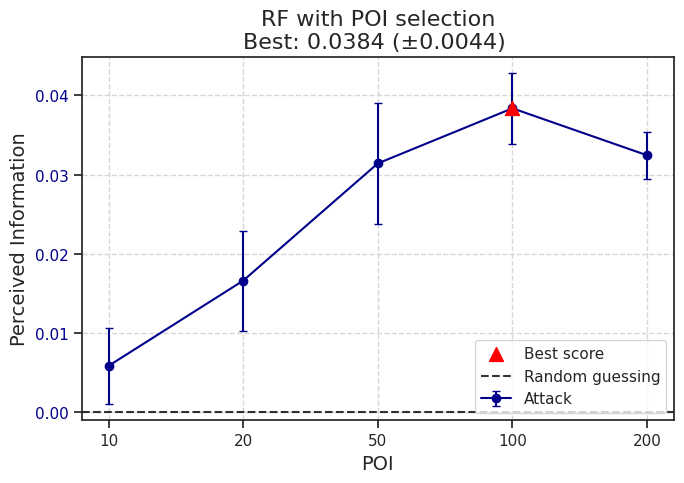

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
plots.plot_gs_results(
    'rf_gini', "RF with POI selection", ax=ax, key='poi', loc='lower right', plot_prof=False
)
plots.savetight(fig, "05_rf_poi")

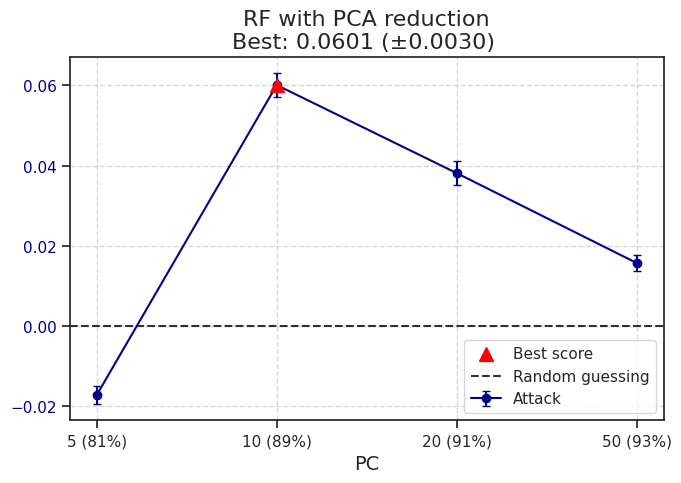

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
plots.plot_gs_results(
    'rf_pca', "RF with PCA reduction", ax=ax, key='pc', xlab='PC', ylab='', loc='lower right', plot_prof=False
)
plots.savetight(fig, "05_rf_pca")

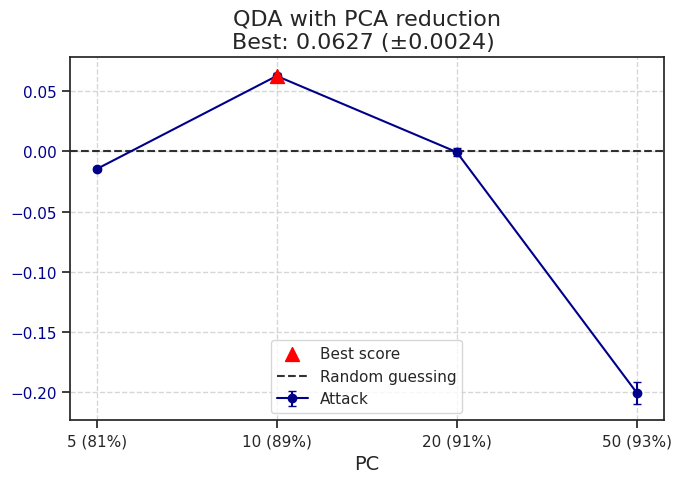

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
plots.plot_gs_results(
    'qda_pca', "QDA with PCA reduction", ax=ax, key='pc', xlab='PC', ylab='', loc='lower center', plot_prof=False
)
plots.savetight(fig, "05_qda_pca")

In [9]:
t = make_pipeline(SelectFromModel(simplerf(SEED), max_features=100))
splits_precomputed = util.precompute_splits(SEED, t, X, y, pts, ks, masks)
pickle.dump(splits_precomputed, open("data/splits_gini.pkl", "wb"))

  0%|          | 0/10 [00:00<?, ?it/s]

Gini -> PCA -> QDA

In [10]:
splits_precomputed = pickle.load(open("data/processed/splits_gini.pkl", "rb"))

In [13]:
gs = []

for pc in [5, 10, 15, 20]:
    pca = PCA(n_components=pc)
    pl = make_pipeline(
        pca, StandardScaler(), QDA(solver='eigen', shrinkage='auto'),
    )
    results, _ = cv_precomputed(pl, splits_precomputed, verbose=False)
    logging.info(f"[{pc}] {results['atk_score_mean'].mean():.4f}")

    gs.append(util.results_to_dict(results, pc=pc, expl=sum(pca.fit(X).explained_variance_ratio_)))
    util.save_results(gs, 'qda_gini_pca')

00:31:10: [5] 0.0057
00:32:13: [10] 0.1008
00:33:28: [15] 0.0646
00:34:57: [20] 0.0212


In [14]:
gs = []

for pc in [5, 10, 15, 20]:
    logging.info(f"Testing GNB + Gini with {pc} PC")

    pca = PCA(n_components=pc)
    pl = make_pipeline(pca, StandardScaler(), GaussianNB())
    results, _ = cv_precomputed(pl, splits_precomputed, verbose=False)

    gs.append(util.results_to_dict(results, pc=pc, expl=sum(pca.fit(X).explained_variance_ratio_)))
    util.save_results(gs, 'gnb_gini_pca')

00:35:01: Testing GNB + Gini with 5 PC
00:35:27: Testing GNB + Gini with 10 PC
00:35:58: Testing GNB + Gini with 15 PC
00:36:33: Testing GNB + Gini with 20 PC


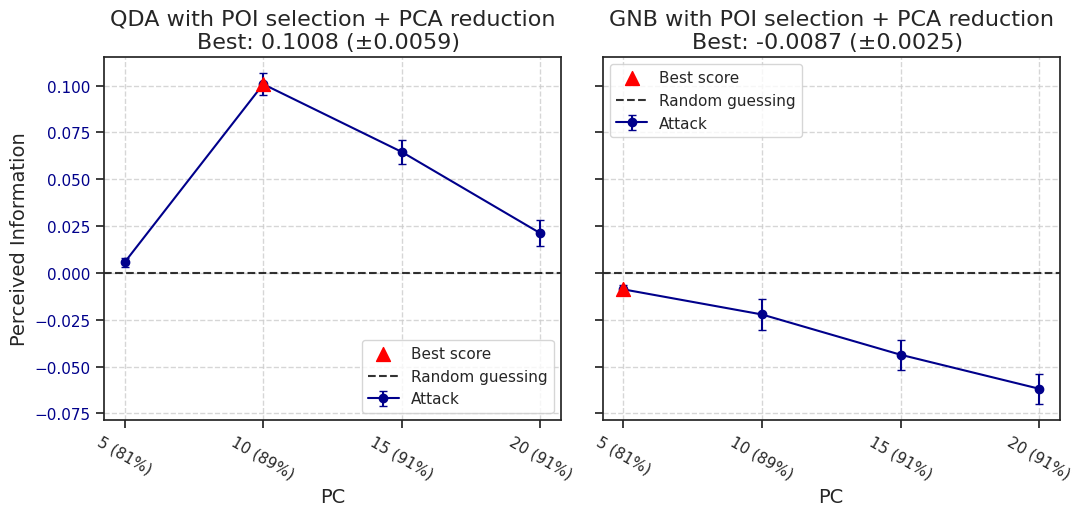

In [3]:
fig, axarr = plt.subplots(1, 2, figsize=(11, 5), sharey=True)
plots.plot_gs_results(
    pd.read_csv('data/results/qda_gini_pca.csv'), "QDA with POI selection + PCA reduction",
    ax=axarr[0], xlab='PC', loc='lower right', key='pc', plot_prof=False
)
plots.plot_gs_results(
    pd.read_csv('data/results/gnb_gini_pca.csv'), "GNB with POI selection + PCA reduction",
    ax=axarr[1], xlab='PC', ylab='', loc='upper left', key='pc', plot_prof=False
)
fig.tight_layout()
plots.rot_labels(axarr, -30)
plots.savetight(fig, "05_qda_gnb_rf_gini_pca")

In [17]:
pca = PCA(n_components=10)
pl = make_pipeline(
    SelectFromModel(simplerf(SEED), max_features=100),
    pca, 
    StandardScaler(),
    QDA(solver='eigen', shrinkage='auto')
)
pl.fit(X, y)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('selectfrommodel', ...), ('pca', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"estimator estimator: objectThe base estimator from which the transformer is built.This can be both a fitted (if ``prefit`` is set to True)or a non-fitted estimator. The estimator should have a``feature_importances_`` or ``coef_`` attribute after fitting.Otherwise, the ``importance_getter`` parameter should be used.",RandomForestC...ndom_state=42)
,"threshold threshold: str or float, default=NoneThe threshold value to use for feature selection. Features whoseabsolute importance value is greater or equal are kept while the othersare discarded. If ""median"" (resp. ""mean""), then the ``threshold`` valueis the median (resp. the mean) of the feature importances. A scalingfactor (e.g., ""1.25*mean"") may also be used. If None and if theestimator has a parameter penalty set to l1, either explicitlyor implicitly (e.g, Lasso), the threshold used is 1e-5.Otherwise, ""mean"" is used by default.",None
,"prefit prefit: bool, default=FalseWhether a prefit model is expected to be passed into the constructordirectly or not.If `True`, `estimator` must be a fitted estimator.If `False`, `estimator` is fitted and updated by calling`fit` and `partial_fit`, respectively.",False
,"norm_order norm_order: non-zero int, inf, -inf, default=1Order of the norm used to filter the vectors of coefficients below``threshold`` in the case where the ``coef_`` attribute of theestimator is of dimension 2.",1
,"max_features max_features: int, callable, default=NoneThe maximum number of features to select.- If an integer, then it specifies the maximum number of features to allow.- If a callable, then it specifies how to calculate the maximum number of features allowed. The callable will receive `X` as input: `max_features(X)`.- If `None`, then all features are kept.To only select based on ``max_features``, set ``threshold=-np.inf``... versionadded:: 0.20.. versionchanged:: 1.1 `max_features` accepts a callable.",100
,"importance_getter importance_getter: str or callable, default='auto'If 'auto', uses the feature importance either through a ``coef_``attribute or ``feature_importances_`` attribute of estimator.Also accepts a string that specifies an attribute name/p

In [19]:
contrib1 = (pca.explained_variance_[:, None] * (pca.components_ ** 2)).sum(axis=0)
contrib1 = contrib1 / contrib1.max()

s1 = pd.Series(pl.named_steps['selectfrommodel'].get_feature_names_out())
s1 = s1.str.replace(r'x(\d+)', r'\1', regex=True).astype(int)

pca_full = PCA(10).fit(X)
contrib2 = (pca_full.explained_variance_[:, None] * (pca_full.components_ ** 2)).sum(axis=0)
contrib2 = contrib2 / contrib2.max()

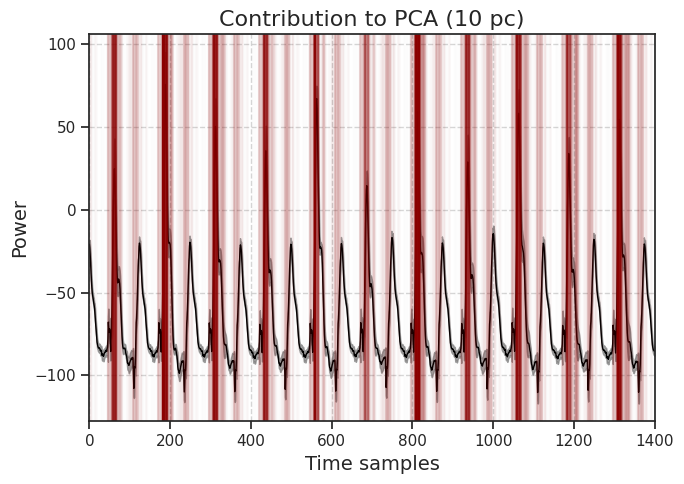

In [23]:
fig, ax = plt.subplots(figsize=(7, 5))
plots.plot_mean_std(X, ax=ax)

for idx, weight in zip(range(len(contrib2)), contrib2):
    ax.axvline(idx, color='darkred', alpha=weight)
plots.labs(ax, xlab="Time samples", ylab="Power",
           title="Contribution to PCA (10 pc)")

fig.tight_layout()
plots.savetight(fig, "05_pca_contrib")

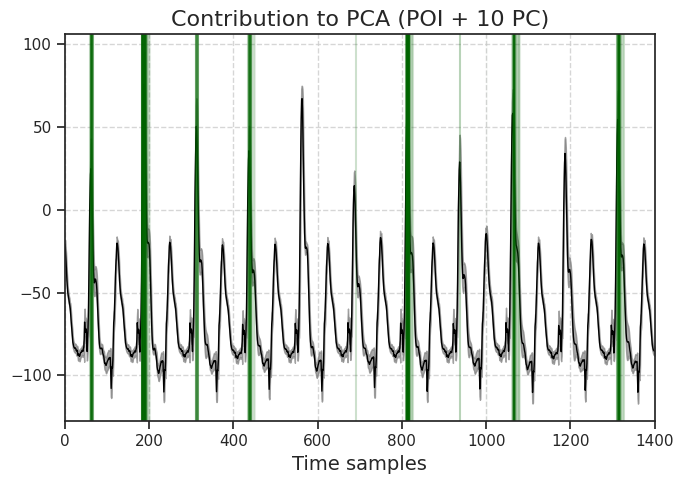

: 

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
plots.plot_mean_std(X, ax=ax)

for idx, weight in zip(s1, contrib1):
    ax.axvline(idx, color='darkgreen', alpha=weight)

plots.labs(ax, xlab="Time samples", ylab="",
           title="Contribution to PCA (POI + 10 PC)")
fig.tight_layout()
plots.savetight(fig, "05_pca_contrib_poi")